In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import spearmanr
import matplotlib.cm as cm

/opt/modules/i12g/anaconda/envs/jupyterhub/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16})

pd.set_option('display.max_rows', 200)

In [4]:
outrider_results = '/data/ceph/hdd/project/node_07/mll/sergey/effect_prediction/outrider/outrider_results/outrider_210223/OUTRIDER_results_AML_panel.tsv'
#outrider_results = '/lustre/groups/epigenereg01/workspace/projects/vale/outrider/outrider_210223/tables/120_random_insignif.csv'

outrider_df = pd.read_csv(outrider_results)
outrider_df['geneName'] = outrider_df.geneID.apply(lambda x:x.split('.')[0])

In [103]:
outrider_df.sampleID.value_counts()

MLL_16239     4
MLL_29068     3
MLL_30856     3
MLL_16241     2
MLL_16593     2
MLL_29345     2
MLL_29371     2
MLL_32452     2
MLL_16686     2
MLL_44131     2
MLL_30839     2
MLL_29049     2
MLL_28605     2
MLL_28828     2
MLL_29377     2
MLL_10660     2
MLL_17743     2
MLL_29041     2
MLL_19073     2
MLL_29369     1
MLL_29337     1
MLL_29365     1
MLL_29354     1
MLL_29516     1
MLL_29084     1
MLL_29079     1
MLL_29078     1
MLL_29075     1
MLL_29072     1
MLL_29502     1
MLL_00268     1
MLL_29529     1
MLL_43954     1
MLL_75303     1
MLL_75191     1
MLL_74402     1
MLL_73933     1
MLL_58068     1
MLL_46281     1
MLL_45153     1
MLL_44612     1
MLL_30886     1
MLL_29531     1
MLL_30882     1
MLL_30877     1
MLL_30875     1
MLL_30874     1
MLL_30858     1
MLL_30843     1
MLL_30834     1
MLL_29692     1
MLL_29058     1
MLL_28829     1
MLL_29048     1
MLL_16597     1
MLL_16242     1
MLL_16235     1
MLL_15976     1
MLL_15213     1
MLL_15199     1
MLL_15031     1
MLL_14748     1
MLL_1466

In [4]:
def get_data(results_dir):
    data = {}
    for gene_results in os.listdir(results_dir):
        geneID = gene_results.split('.')[0]
        with open(results_dir + gene_results, 'rb') as f:
            data[geneID] = pickle.load(f)
    return data


def compute_log2fc(data, targets_idx):
    
    predictions = []
    
    for geneID, samples in data.items():
        for sample, preds in samples.items():
            #log2fc = np.log2(preds['alt'][targets_idx]/preds['ref'][targets_idx]).mean()
            log2fc = np.log2(preds['alt'][:,targets_idx].mean(axis=0)/preds['ref'][:,targets_idx].mean(axis=0)).mean()
            predictions.append((geneID, sample, log2fc))
            
    predictions.sort(key = lambda x:-abs(x[2]))
    predictions = pd.DataFrame(predictions, columns=['geneName','VCF_file','enformer_log2fc'])
    
    return predictions

In [5]:
dnase_all_idx = np.array(np.arange(0,674)) 

cage_all_idx = np.array(np.arange(4675,5313)) 

chipseq_all_idx = np.array(np.arange(674,4675)) 

all_idx = np.hstack((dnase_all_idx, cage_all_idx))

cage_aml_idx = np.array(np.arange(5182,5194)) 
cage_aml_idx = np.insert(cage_aml_idx,0,(4716,4717,4718,5026,5046, 5220, 5249, 5250, 5251, 5252))

targets = {'chipseq':chipseq_all_idx, 'dnase':dnase_all_idx, 
           'cage':cage_all_idx, 'all':all_idx, 'cage_aml':cage_aml_idx}

In [11]:
#out_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/outrider/outrider_210223/insignificant_genes/'

out_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/outrider/outrider_210223/aml/'

all_res = []

for gnomAD_AF in ('5e-4','1'):
    for promoter_size in (2000, 5000, 10000, 25000, 50000):
        for promoter_direction in ('symm', 'left'):
            results_dir = out_dir + f'max_gnomAD_{gnomAD_AF}/promoters_{promoter_size}_{promoter_direction}/'
            data = get_data(results_dir)
            for target in 'chipseq', 'dnase', 'cage',  'cage_aml':
                targets_idx = targets[target]
                predictions = compute_log2fc(data, targets_idx)
                res_df = outrider_df.merge(predictions)
                if 'l2fc' in outrider_df.columns:
                    sp_cor = spearmanr(res_df.l2fc, res_df.enformer_log2fc)
                    sp_cor = (sp_cor.correlation, sp_cor.pvalue)
                else:
                    sp_cor = [None,None]
                all_res.append((float(gnomAD_AF), promoter_direction, promoter_size, target, *sp_cor))
                
                

In [ ]:
all_res = pd.DataFrame(all_res, columns = ['gnomAD_AF','promoter_dir','length', 'targets', 'spearmanr', 'spearmanr_pvalue'])

In [8]:
all_res[~all_res.spearmanr_pvalue.isna()].sort_values(by='spearmanr_pvalue').head(10)

,gnomAD_AF,promoter_dir,length,targets,spearmanr,spearmanr_pvalue
18,0.0005,symm,10000,cage,0.463174,0.026029
16,0.0005,symm,10000,chipseq,0.443895,0.033852
46,1.0000,left,2000,cage,0.900000,0.037386
45,1.0000,left,2000,dnase,0.900000,0.037386
29,0.0005,left,25000,dnase,0.341030,0.088206
56,1.0000,symm,10000,chipseq,0.255221,0.098583
57,1.0000,symm,10000,dnase,0.253182,0.101398
17,0.0005,symm,10000,dnase,0.332674,0.120893
21,0.0005,left,10000,dnase,0.466670,0.126163
67,1.0000,symm,25000,cage_aml,-0.154082,0.183867


In [12]:
def plot_predictions(predictions, ax, jitter=0.1):

    res_df = outrider_df.merge(predictions,how='left')
    res_df.enformer_log2fc = res_df.enformer_log2fc.fillna(0)

    x_low, x_high = -6,2

    p_95 = np.percentile(abs(res_df.enformer_log2fc),95)

    ax.scatter(res_df.l2fc, res_df.enformer_log2fc, c=res_df.index, marker='.', s=300, cmap='rainbow')

    ax.plot(np.linspace(x_low, x_high),-np.ones((50,))*p_95, linestyle='--',color='lightgray')
    ax.plot(np.linspace(x_low, x_high),np.ones((50,))*p_95, linestyle='--',color='lightgray')

    ax.set_xlim((x_low, x_high))

    for pair_idx, l2fc, enformer_l2fc in res_df.reset_index()[['index','l2fc','enformer_log2fc']].values:
        if enformer_l2fc<-p_95 or enformer_l2fc>p_95:
            ax.annotate(int(pair_idx), (l2fc+(np.random.rand()*2-1)*jitter*l2fc, enformer_l2fc+(np.random.rand()*2-1)*jitter*enformer_l2fc), weight="bold")
            

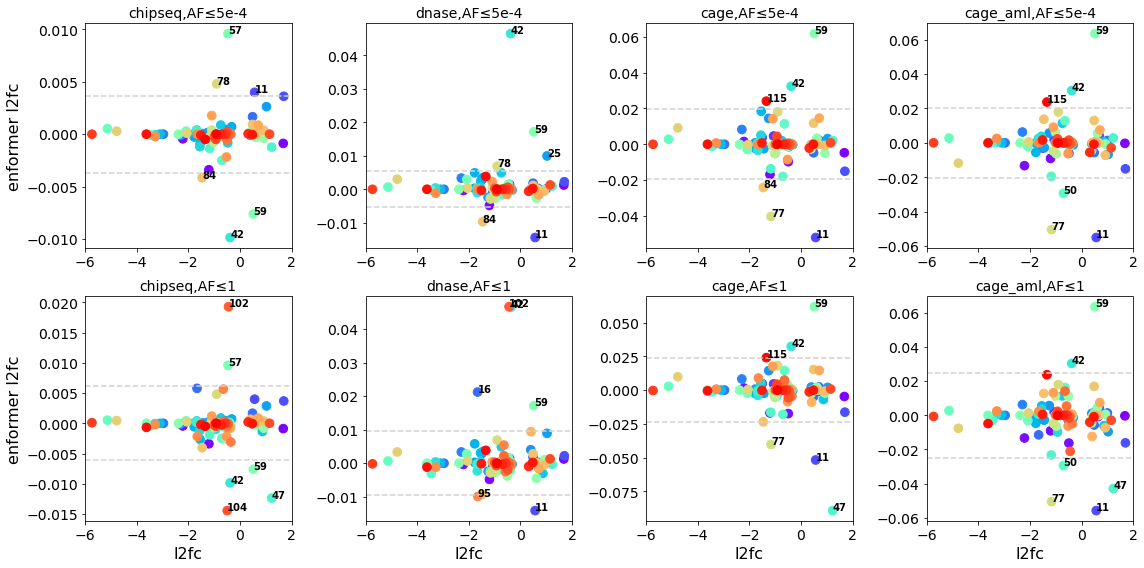

In [48]:
out_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/outrider/outrider_210223/aml/'

fig, axes = plt.subplots(2,4, figsize=(16,8))

axes = axes.flatten()

ax_idx = 0

for gnomAD_AF in '5e-4', '1',:
    
    data = get_data(out_dir + 
                        f'max_gnomAD_{gnomAD_AF}/promoters_50000_symm/')
        
    for target in 'chipseq', 'dnase', 'cage', 'cage_aml':
     
        ax = axes[ax_idx]

        predictions = compute_log2fc(data, targets[target])


        res_df=plot_predictions(predictions, ax, jitter=0)

        ax.set_title(f'{target},AF≤{gnomAD_AF}')
        
        if ax_idx>3:
            ax.set_xlabel('l2fc')
        
        ax_idx += 1
        
axes[0].set_ylabel('enformer l2fc')
axes[4].set_ylabel('enformer l2fc')

fig.tight_layout()

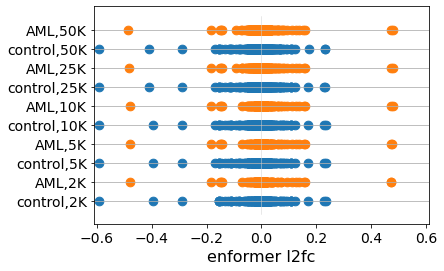

In [99]:
target = 'cage'

lustre_common = '/lustre/groups/epigenereg01/workspace/projects/vale/outrider/outrider_210223/'

height = 0

fig, ax = plt.subplots()

ylabels = []

ax.plot(np.zeros((50,)), np.linspace(-0.7,9.7), color='lightgray', linewidth=0.5)

for promoter_length in (2000,5000,10000,25000,50000): 


    aml_dir = lustre_common + f'aml/max_gnomAD_5e-4/promoters_{promoter_length}_symm/'
    insign_dir = lustre_common + f'insignificant_genes/max_gnomAD_5e-4/promoters_{promoter_length}_symm/'


    for out_dir in (insign_dir,aml_dir):
                
        data = get_data(out_dir)

        x = compute_log2fc(data, targets[target]).enformer_log2fc

        ax.scatter(x, np.ones((len(x),)) * height, c='tab:orange' if height%2 else 'tab:blue', marker='.', s=300)
        
        if out_dir==aml_dir:
            ylabels.append(f'AML,{promoter_length//1000}K')
        else:
            ylabels.append(f'control,{promoter_length//1000}K')
            
        
        height += 1
        
ax.set_yticks(np.arange(10))    
ax.set_yticklabels(ylabels);

ax.set_xlim([-0.61,0.61])


ax.yaxis.grid()
ax.set_xlabel('enformer l2fc');

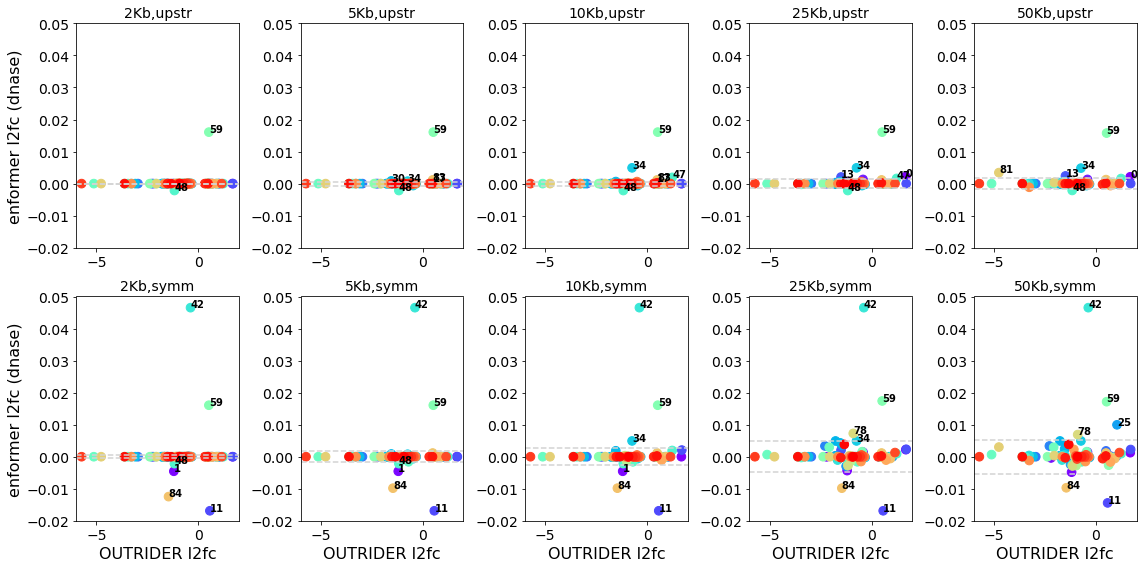

In [18]:
target = 'dnase'

fig, axes = plt.subplots(2,5, figsize=(16,8))

axes = axes.flatten()

ax_idx = 0

for promoter_dir in 'left', 'symm':
    for promoter_length in (2000,5000,10000,25000,50000):
     
        ax = axes[ax_idx]
        
        data = get_data(out_dir + 
                        f'max_gnomAD_5e-4/promoters_{promoter_length}_{promoter_dir}/')

        predictions = compute_log2fc(data, targets[target])


        res_df=plot_predictions(predictions, ax, jitter=0)

        ax.set_title(f'{promoter_length//1000}Kb,{promoter_dir.replace("left","upstr")}')
        
        if ax_idx>4:
            ax.set_xlabel('OUTRIDER l2fc')
            
        #ax.set_ylim((-0.065,0.065)) #cage
        ax.set_ylim((-0.02,0.05)) #dnase
        
        ax_idx += 1
        
axes[0].set_ylabel(f'enformer l2fc ({target})')
axes[5].set_ylabel(f'enformer l2fc ({target})')

fig.tight_layout()

In [26]:
outrider_df.iloc[[59,42,84,11,1,78,115,77,50]]

,sampleID,hgncSymbol,geneID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank,foldChange,Diag,VCF_file,RNA_file
59,MLL_28859,NPM1,ENSG00000181163,4.267258e-13,2.929561e-08,6.54,0.52,79686,24202.71,16884.10,358.82,True,12,15,2.0,1.43,AML,NovaSeq_Male_MLL_28859-M084_G1_P1.somatic.vcf.gz,MLL_28859-M007.alignments.bam
42,MLL_17744,NPM1,ENSG00000181163,2.369311e-06,2.502433e-02,-4.70,-0.38,51373,12999.09,16884.10,358.82,True,14,15,12.0,0.77,AML,comb-MaleCon_comb-MLL_17744_G1_P1.somatic.vcf.gz,MLL_17744-M009.alignments.bam
84,MLL_29377,RUNX1,ENSG00000159216,3.392538e-09,4.658096e-05,-6.68,-1.46,1025,780.59,2132.86,48.79,True,29,6,10.0,0.36,AML,NovaSeq_Female_MLL_29377-M008_G1_P1.somatic.vc...,MLL_29377-M056.alignments.bam
11,MLL_13811,CREBBP,ENSG00000005339,4.549133e-16,6.246148e-11,7.28,0.57,8068,5604.35,3749.93,383.47,True,27,8,1.0,1.48,AML,NovaSeq_Female_MLL_13811-M084_G1_P1.somatic.vc...,MLL_13811-M063.alignments.bam
1,MLL_10419,TNFRSF14,ENSG00000157873,3.741928e-07,2.568911e-02,-5.67,-1.20,157,282.04,651.13,60.07,True,4,5,2.0,0.44,AML,-M058_comb-MLL_10419_G1_P1.somatic.vcf.gz,MLL_10419-M025.alignments.bam
78,MLL_29354,SH2B3,ENSG00000111252,1.162960e-06,9.979953e-03,-5.12,-0.90,2977,1497.38,2782.74,77.23,True,18,2,16.0,0.54,AML,NovaSeq_Male_MLL_29354-M012_G1_P1.somatic.vcf.gz,MLL_29354-M028.alignments.bam
115,MLL_75303,PHF6,ENSG00000156531,3.858357e-11,2.648842e-06,-6.98,-1.34,535,299.98,756.63,73.55,True,7,11,2.0,0.40,AML,NovaSeq_Male_MLL_75303-M026_G1_P1.somatic.vcf.gz,MLL_75303-M078.alignments.bam
77,MLL_29345,TP53,ENSG00000141510,1.768252e-06,4.046473e-02,-4.72,-1.16,416,233.22,518.04,50.05,True,6,20,6.0,0.45,AML,HiSeq-FemaleCon_comb-MLL_29345_G1_P1.somatic.v...,MLL_29345-M015.alignments.bam
50,MLL_19060,STAG2,ENSG00000101972,1.594554e-10,1.841080e-05,-6.74,-0.70,3849,4332.95,6992.46,214.65,True,8,22,1.5,0.62,AML,NovaSeq_Male_MLL_19060-M016_G1_P1.somatic.vcf.gz,MLL_19060-M073.alignments.bam


In [65]:
data = get_data(out_dir + f'max_gnomAD_5e-4/promoters_5000_symm/')

predictions = compute_log2fc(data, targets['dnase'])

res_df = outrider_df.merge(predictions,how='left')
res_df.enformer_log2fc = res_df.enformer_log2fc.fillna(0)

In [19]:
promoter_variants = pd.read_csv('/lustre/groups/epigenereg01/workspace/projects/vale/outrider/promoter_variants/max_gnomAD_5e-4/promoters_5000_symm.tsv',
                               sep='\t', names = ['VCF_file','geneName'], usecols=[4,5])

In [20]:
promoter_counts = (promoter_variants.VCF_file + ' ' + promoter_variants.geneName).value_counts().reset_index(name='N_variants')

In [21]:
promoter_counts['VCF_file'] = promoter_counts['index'].apply(lambda x:x.split()[0])
promoter_counts['geneName'] = promoter_counts['index'].apply(lambda x:x.split()[1])
promoter_counts.drop(columns='index', inplace=True)

In [69]:
res_df = res_df.merge(promoter_counts, how='left').drop(columns='geneName')
res_df.N_variants = res_df.N_variants.fillna(0)

In [71]:
#res_df.to_csv('OUTRIDER_results_AML_panel_Enformer_5k.tsv',sep='\t')

In [72]:
!pwd

/home/icb/sergey.vilov/workspace/enformer/outrider


In [8]:
var_counts = {}

promoters_dir = '/s/project/mll/sergey/effect_prediction/outrider/aml_genes/promoter_variants/max_gnomAD_5e-4/'
#promoters_dir = '/s/project/mll/sergey/effect_prediction/outrider/aml_genes/insignificant_genes/max_gnomAD_5e-4/'

for promoter_length in (2000,5000,10000,25000,50000):

    promoters_tsv = promoters_dir + f'promoters_{promoter_length}_left.tsv'
    
    promoter_variants = pd.read_csv(promoters_tsv,
                                   sep='\t', names = ['VCF_file','geneName'], usecols=[4,5])

    promoter_counts = (promoter_variants.VCF_file + ' ' + promoter_variants.geneName).value_counts().reset_index(name='N_variants')

    promoter_counts['VCF_file'] = promoter_counts['index'].apply(lambda x:x.split()[0])
    promoter_counts['geneName'] = promoter_counts['index'].apply(lambda x:x.split()[1])
    promoter_counts.drop(columns='index', inplace=True)

    res_df = outrider_df.merge(promoter_counts, how='left')
    res_df.N_variants = res_df.N_variants.fillna(0)
    var_counts[promoter_length] = (res_df.N_variants.mean(),res_df.N_variants.std())

In [9]:
var_counts

{2000: (0.017094017094017096, 0.13017931816417444),
 5000: (0.06837606837606838, 0.2534756917712068),
 10000: (0.11965811965811966, 0.3751411955424058),
 25000: (0.26495726495726496, 0.5316396626631547),
 50000: (0.5811965811965812, 0.8432216160543528)}

In [6]:
import seaborn as sns

sns.barplot(x=list(var_counts), y=list(var_counts.values()))

plt.ylim([0,1.4])

KeyError: (0.05128205128205128, 0.22152114580133264)